In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from skimage.transform import radon
from tqdm import tqdm
from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.decomposition import PCA
import sys
sys.path.append('../')
from augmentation import *
import seaborn as sns
from utils import *
import seaborn as sns
from torch import nn
from jintao import *
from model import *
import torchvision.models as models
from torchinfo import summary

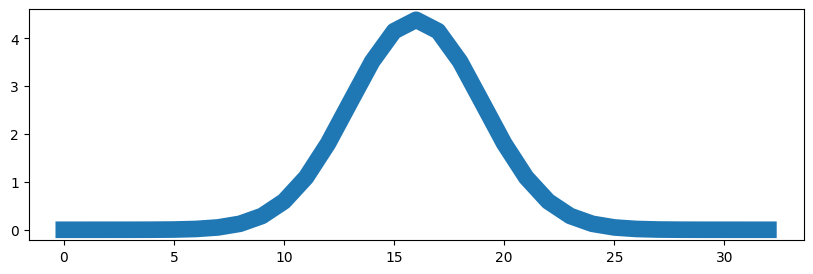

In [11]:
def gauss_window(w,sigma):
    # Create a tensor for the window
    window = torch.arange(w).float()
    # Calculate the Gaussian function
    window = torch.exp(-0.5 * ((window - (w) // 2) / sigma) ** 2)
    # Normalize the window
    window /= window.sum()
    return window * w
window = gauss_window(33,3)
plt.figure(figsize=(10,3))
plt.plot(window,linewidth=12)

In [2]:
class Token_Transformer_paper(nn.Module):
    def __init__(self, *, seqlen, channel, ext, dim, depth, heads, mlp_dim, channels=1, dropout=0.3):
        super().__init__()
        patch_dim = seqlen
        self.nvar = channel
        self.ext = ext
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.c_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(
                        FullAttention(False, 1, attention_dropout=0.1,
                                      output_attention=True), dim, heads),
                    dim,
                    mlp_dim,
                    dropout=0.1,
                    activation='gelu'
                ) for l in range(depth)
            ],
            norm_layer=torch.nn.LayerNorm(dim))
        
        self.to_c_token = nn.Identity()
        pe = PositionalEncoding1D(embed_dim=dim).position_encoding.unsqueeze(2).unsqueeze(3)
        self.register_buffer('pe',pe)
        self.dropout = nn.Dropout(0.1)
        # self.position_emb = nn.Linear(2, dim)
        self.sim = torch.nn.CosineSimilarity(dim=-1)
        self.window = self.gauss_window(seqlen,3)
        self.window.requires_grad=True
    def gauss_window(self,w,sigma):
        # Create a tensor for the window
        window = torch.arange(w).float()
        # Calculate the Gaussian function
        window = torch.exp(-0.5 * ((window - (w) // 2) / sigma) ** 2)
        # Normalize the window
        window /= window.sum()
        return window * w
    def forward(self, forward_seq, epoch=50,attn_mask=None,):
         # forward_seq: b * nvar * ext * channel/None * seq
        # x = self.pe(x)
        print(forward_seq.grad_fn)
        x = forward_seq * self.window.to(forward_seq.device)
        print(x.grad_fn)
        if len(x.shape)<5:
            x = x.unsqueeze(3)
        # print(x.shape)
        bs , nvar , ext , channel , seq = x.shape
        # print(x.shape)
        x = x.transpose(1,2)# x: b , ext , nvar , channel , seq 
        m = self.patch_to_embedding(x)
        # if ext == 999:
        #     m = m + self.pe[:,:x.shape[1]]
        #     m = self.dropout(m)
        
        # m = m.reshape(bs,-1,m.shape[-1])#see ext as attrs
        m = m.reshape(bs*ext,-1,m.shape[-1])#see ext as one sample,use smooth loss
        
        b, n, _ = m.shape
        c_tokens = repeat(self.c_token, '() n d -> b n d', b=b)
        x = torch.cat((c_tokens, m), dim=1)
        x,attn = self.transformer(x,attn_mask)
        c_t = self.to_c_token(x[:, 0])
        c_t = F.normalize(c_t,dim=1)
        c_t = c_t.reshape(bs,ext,-1) # use smooth loss 
        if ext > 1 and epoch > 10:
            weight = self.sim(c_t.unsqueeze(1),c_t.unsqueeze(2))[:,int((ext-1)/2)] ** 0
            weight[:,int((ext-1)/2)] = 0
            weight = weight/weight.sum(-1,True)
            r_t = (c_t * weight.unsqueeze(2)).sum(1)
            a = 0.5
            c_t = a * c_t[:,int((ext-1)/2)] + (1-a) * r_t
            c_t = F.normalize(c_t,dim=-1)
        else:
            c_t = c_t[:,int((ext-1)/2)]
        
        return c_t, attn # use smooth loss
        # return c_t, c_t # see ext as attrs

In [3]:
a = torch.ones(2,9,1,11)
model = Token_Transformer_paper(seqlen=11, channel=9, ext=1, dim=16, depth=2, heads=2, mlp_dim=32)
x1,x2 = model(a)
x1.grad_fn

None


In [4]:
conv = nn.Conv1d(3, 12, kernel_size=3,
                      stride=1, bias=False, padding='same',groups=3)
conv2 = nn.Conv1d(12, 12, kernel_size=3,
                      stride=1, bias=False, padding='same',groups=3)

In [5]:
a = torch.tensor([[1,1,1,1,1],
                  [100000,100000,100000,100000,100000],
                  [10000000000,10000000000,10000000000,10000000000,10000000000]]).unsqueeze(0).unsqueeze(2).float()
bs,nvar,ext,seqlen = a.shape
x = a.transpose(1,2)
x = x.reshape(-1,nvar,seqlen)
x = conv(x)
xx = conv2(x)
x,xx,xx.reshape(1,3,12//3,-1)
# x = x.reshape(bs,ext,-1,seqlen)
# x = x.transpose(1,2)
# # x : bs,nvar*channel,ext,seqlen
# x = x.reshape(bs,nvar,-1,ext,seqlen)
# # x : bs,nvar,channel,ext,seqlen
# n0 = torch.randint(1,nvar+1,size=(1,)).item()
# l = torch.randperm(nvar)[:n0].tolist()
# x = x[:,l]
# x = x.reshape(bs,-1,ext,seqlen)
# x,l

(tensor([[[-5.1695e-01, -1.0902e+00, -1.0902e+00, -1.0902e+00, -5.1582e-01],
          [-2.0028e-01,  2.5370e-01,  2.5370e-01,  2.5370e-01,  7.4348e-01],
          [ 5.8359e-01,  7.2779e-01,  7.2779e-01,  7.2779e-01,  4.9376e-01],
          [-1.0681e-02, -2.6025e-02, -2.6025e-02, -2.6025e-02,  2.7085e-01],
          [ 5.0522e+04,  5.9035e+04,  5.9035e+04,  5.9035e+04,  1.9749e+04],
          [-4.8137e+03,  4.2185e+04,  4.2185e+04,  4.2185e+04,  6.8228e+04],
          [ 7.1560e+03,  6.4657e+04,  6.4657e+04,  6.4657e+04,  1.0687e+05],
          [-3.4021e+03,  2.1267e+04,  2.1267e+04,  2.1267e+04,  5.0167e+04],
          [ 4.4794e+09, -5.3794e+08, -5.3794e+08, -5.3794e+08, -4.1305e+09],
          [ 1.4085e+09,  7.1797e+08,  7.1797e+08,  7.1797e+08, -2.0329e+09],
          [-2.7379e+09,  7.6182e+08,  7.6182e+08,  7.6182e+08, -1.9285e+09],
          [-5.1041e+09, -1.2123e+09, -1.2123e+09, -1.2123e+09, -1.3531e+09]]],
        grad_fn=<SqueezeBackward1>),
 tensor([[[-6.0427e-03,  2.0116e-01, 

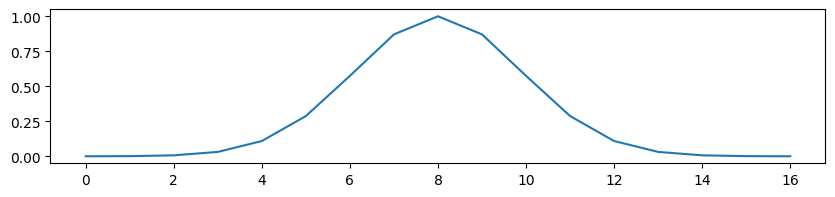

In [7]:

def gauss_window(w,sigma):
        # Create a tensor for the window
        window = torch.arange(w).float()
        # Calculate the Gaussian function
        window = torch.exp(-0.5 * ((window - (w) // 2) / sigma) ** 2)
        # Normalize the window
        # window /= window.sum()
        return window 
w = gauss_window(17,1.9)
# plt.plot(b[0,0])
plt.figure(figsize=(10,2))
plt.plot(w)
# plt.plot(sx[0,0,10-8:10+9])
# plt.plot(sx[0,0,10-8:10+9] * w.numpy())
# plt.plot(b[0,0]/w)
# plt.legend(['sx*w','sx'])

In [15]:
a = np.ones((30,30,17))
a*w.numpy()

array([[[0.00014135, 0.00112868, 0.00683192, ..., 0.00683192,
         0.00112868, 0.00014135],
        [0.00014135, 0.00112868, 0.00683192, ..., 0.00683192,
         0.00112868, 0.00014135],
        [0.00014135, 0.00112868, 0.00683192, ..., 0.00683192,
         0.00112868, 0.00014135],
        ...,
        [0.00014135, 0.00112868, 0.00683192, ..., 0.00683192,
         0.00112868, 0.00014135],
        [0.00014135, 0.00112868, 0.00683192, ..., 0.00683192,
         0.00112868, 0.00014135],
        [0.00014135, 0.00112868, 0.00683192, ..., 0.00683192,
         0.00112868, 0.00014135]],

       [[0.00014135, 0.00112868, 0.00683192, ..., 0.00683192,
         0.00112868, 0.00014135],
        [0.00014135, 0.00112868, 0.00683192, ..., 0.00683192,
         0.00112868, 0.00014135],
        [0.00014135, 0.00112868, 0.00683192, ..., 0.00683192,
         0.00112868, 0.00014135],
        ...,
        [0.00014135, 0.00112868, 0.00683192, ..., 0.00683192,
         0.00112868, 0.00014135],
        [0.0

In [3]:
n3,n2,n1 = 576,1767,21
path = "../../../data/jintao/"
sx = np.fromfile(path+"sx.dat", dtype = np.float32).reshape(n3,n2,n1)
sx = xnorm(sx,True,99,1)

hor = np.fromfile(path+"p10.dat", dtype = np.float32).reshape(n3,n2)

coherent_energy = np.fromfile(path+"coherent_energy.dat", dtype = np.float32).reshape(n3,n2,n1)
coherent_energy = xnorm(coherent_energy,True,99,1)

k_curvedness = np.fromfile(path+"k_curvedness.dat", dtype = np.float32).reshape(n3,n2,n1)
k_curvedness = xnorm(k_curvedness,True,99,1)

glcm_homogeneity = np.fromfile(path+"glcm_homogeneity.dat", dtype = np.float32).reshape(n3,n2,n1)
glcm_homogeneity = xnorm(glcm_homogeneity,True,99,1)

peak_freq_cmp = np.fromfile(path+"peak_freq_cmp.dat", dtype = np.float32).reshape(n3,n2,n1)
peak_freq_cmp = xnorm(peak_freq_cmp,True,99,1)

peak_mag_cmp = np.fromfile(path+"peak_mag_cmp.dat", dtype = np.float32).reshape(n3,n2,n1)
peak_mag_cmp = xnorm(peak_mag_cmp,True,99,1)

sobel_filter_similarity = np.fromfile(path+"sobel_filter_similarity.dat", dtype = np.float32).reshape(n3,n2,n1)
sobel_filter_similarity = xnorm(sobel_filter_similarity,True,99,1)

kmeansp = '../../../log4/jintao/predict/kmeans/cnn1d_encoder/simple_freezy_w10_s0_addpos/ssl/ts_tcc/cnn1d_encoder/Warp_aug+jitter_w10_s0_addpos/60/fe+te/Kmeans_6.dat'
kmeans = np.fromfile(kmeansp, dtype = np.float32).reshape(n3,n2)
attrs = {'sx':sx,
         'coherent_energy':coherent_energy,
         'k_curvedness':k_curvedness,
         'peak_freq_cmp':peak_freq_cmp,
         'peak_mag_cmp':peak_mag_cmp,
         'sobel_filter_similarity':sobel_filter_similarity,}

3.1072905 -2.7324793 7.1388038e-09 1.0
5.824085 -0.7050543 -3.9550456e-09 0.9999998
3.6147828 -1.3952106 -2.5622843e-08 0.9999998
2.38148 -2.080696 -2.1527871e-08 0.9999999
4.239702 -1.191305 -1.8645828e-08 0.9999997
0.9628161 -3.0698583 -5.0266205e-09 1.0000005


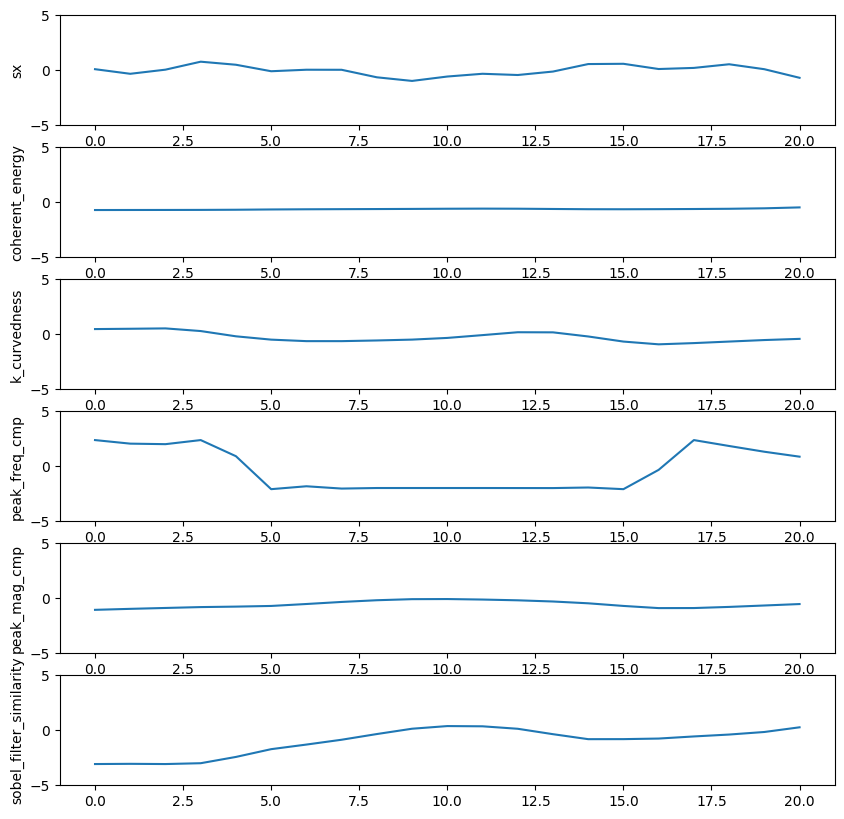

In [45]:
plt.figure(figsize=(10,10))
for i,(name,dat) in enumerate(attrs.items()):
    plt.subplot(6,1,i+1)
    plt.plot(dat[500,280,:])
    plt.ylabel(name)
    plt.ylim([-5,5])
    print(dat.max(),dat.min(),dat.mean(),dat.std())

In [7]:
def drop_error_value(x,upper=95,floor=5):
    upper_value = np.percentile(x, upper)
    floor_value = np.percentile(x, floor)
    data = np.where(((x>upper_value)), upper_value, x)
    data = np.where(((x<floor_value)), floor_value, data)
    return data

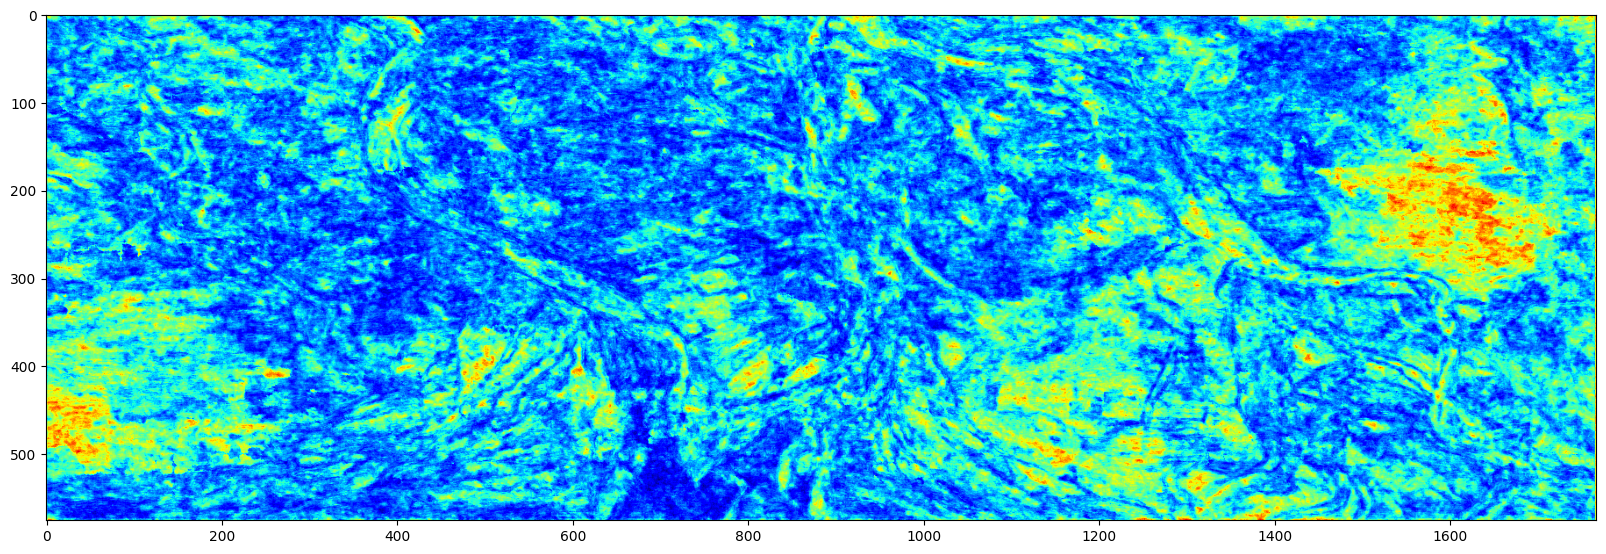

In [9]:
#plt.figure(figsize=(20,20))

plt.imshow((glcm_homogeneity)[:,:,17:27].sum(-1),cmap='jet')

In [35]:
coherent_energy = xnorm(np.fromfile(path+"coherent_energy.dat", dtype = np.float32).reshape(n3,n2,n1))
sx_hor = np.zeros_like(hor)
for i in range(hor.shape[0]):
    for j in range(hor.shape[1]):
        sx_hor[i,j] = coherent_energy[i,j,round(hor[i,j])]

mean_before:  34102180.0
std_before:  54618440.0
mean_last:  34102180.0
std_last:  54618440.0


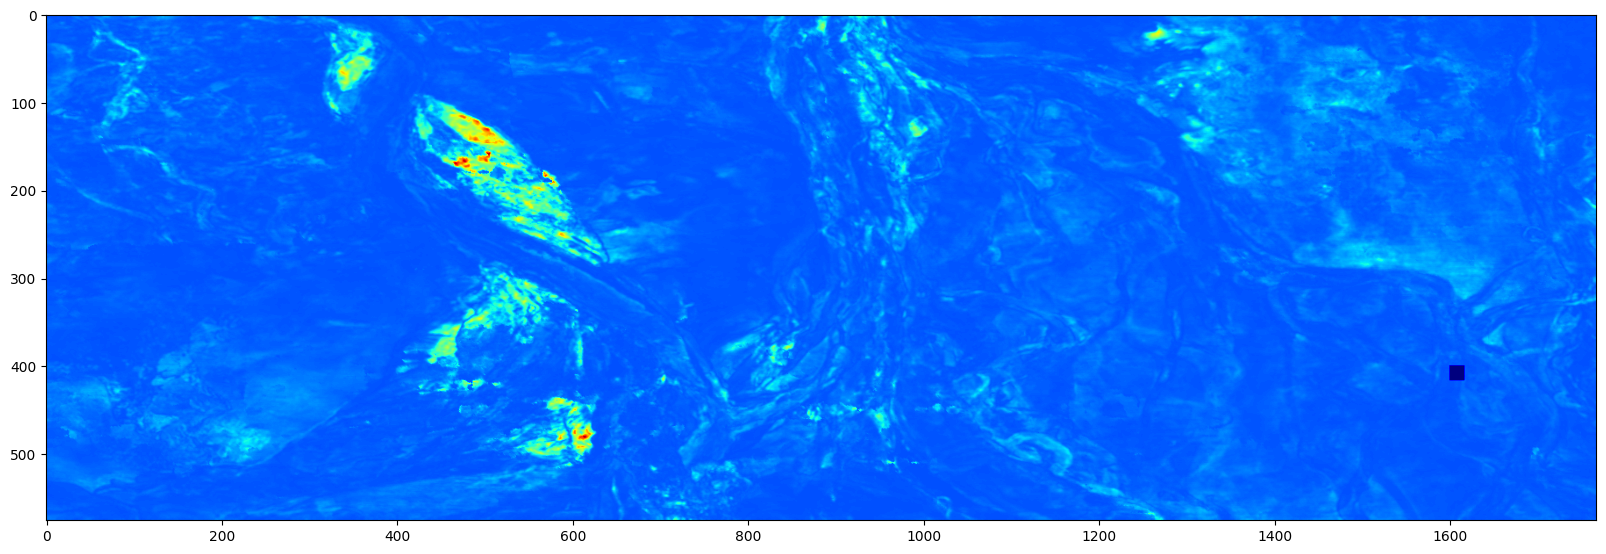

In [37]:
plt.figure(figsize=(20,20))
sx_hor[400:417,1600:1617] = -5
plt.imshow(sx_hor,cmap='jet')

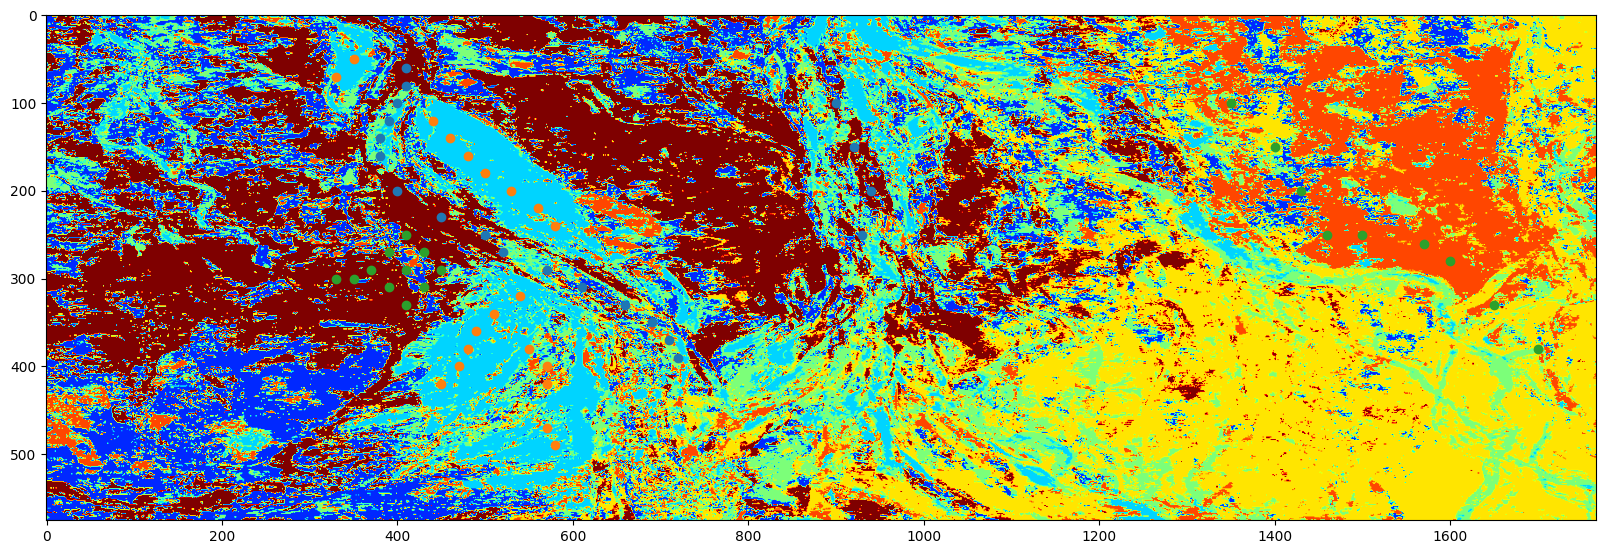

In [13]:
plt.figure(figsize=(20,20))
plt.imshow(coherent_energy,cmap='jet')
point1 = [[60,410],[80,410],[100,400],[120,390],[140,380],[160,380],[200,400],[230,450],[250,500],[270,520],
         [290,570],[310,610],[330,660],[350,690],[370,710],[390,720],[100,900],[150,920],[200,940],[250,930]]
point2 = [[50,350],[70,330],[120,440],[140,460],[160,480],[180,500],[200,530],[220,560],[240,580],
        [320,540],[340,510],[360,490],[380,480],[400,470],[420,450],[380,550],[400,570],[420,570],
        [470,570],[490,580]]
point3 = [[100,1350],[150,1400],[200,1430],[250,1460],[250,1500],[260,1570],[280,1600],[330,1650],
        [380,1700],[290,450],[270,430],[250,410],[270,390],[290,410],[310,430],[290,370],[310,390],
        [330,410],[300,350],[300,330]]
point1 = np.array(point1)
point2 = np.array(point2)
point3 = np.array(point3)
plt.scatter(point1[:,1],point1[:,0])
plt.scatter(point2[:,1],point2[:,0])
plt.scatter(point3[:,1],point3[:,0])

<Axes: ylabel='Density'>

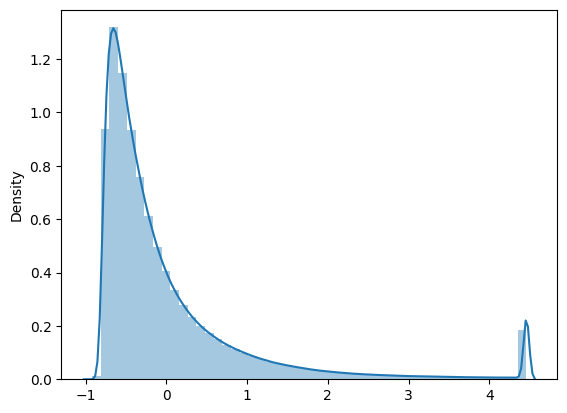

In [5]:

sns.distplot(coherent_energy)

In [53]:
def get_hor(sx,hor,window):
    sx_hor = np.zeros((sx.shape[0],sx.shape[1],2*window+1))
    for i in range(hor.shape[0]):
        for j in range(hor.shape[1]):
            sx_hor[i,j] = sx[i,j,round(hor[i,j])-window:round(hor[i,j])+window+1]
    return sx_hor
def get_attrs_kmeans(attrs,cluster,window,hor):
    _,ax = plt.subplots(len(attrs),1,figsize=(8,3*len(attrs)))
    for i,(key,sx) in enumerate(attrs.items()):
        sx_hor = get_hor(sx,hor,window)
        if window >0:
            features = sx_hor.reshape(-1,2*window+1)
            kmeans = MiniBatchKMeans(init='k-means++', n_clusters=cluster, random_state=42,batch_size=100000,
                            verbose=0).fit(features)
            mat = kmeans.labels_.reshape(n3,n2)
            ax[i].imshow(mat,cmap='jet')
            ax[i].set_title(key)
        else:
            mat = sx_hor
            ax[i].imshow(mat,cmap='jet')
            ax[i].set_title(key)

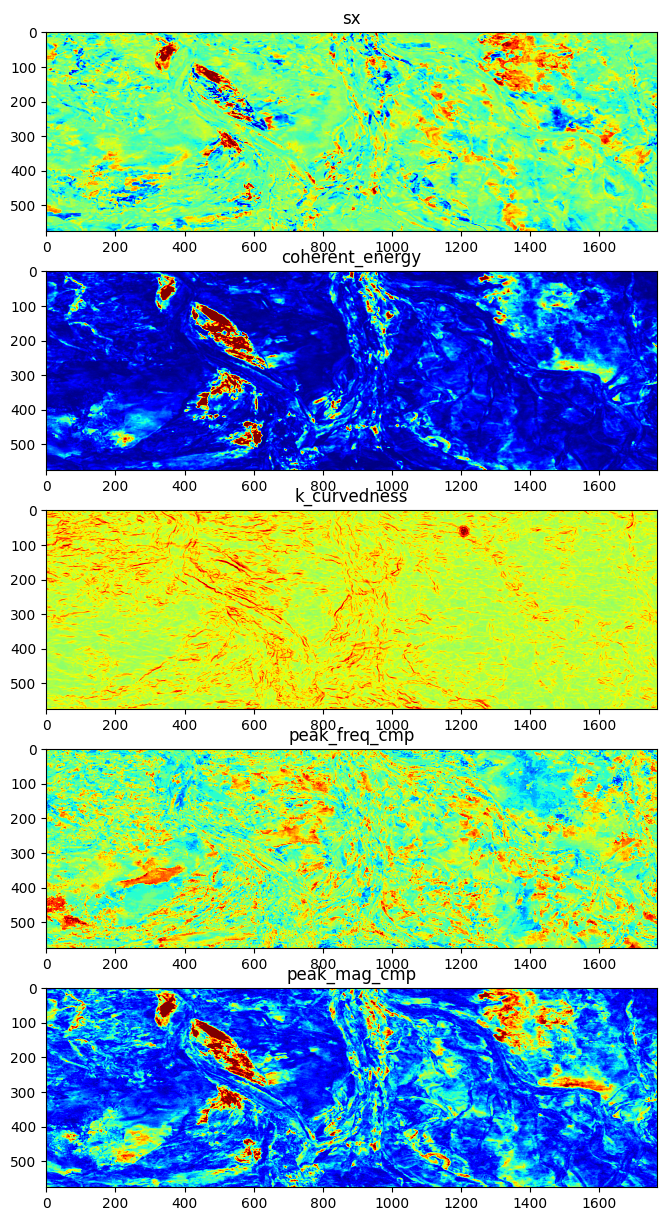

In [112]:
get_attrs_kmeans(attrs,6,0,hor)

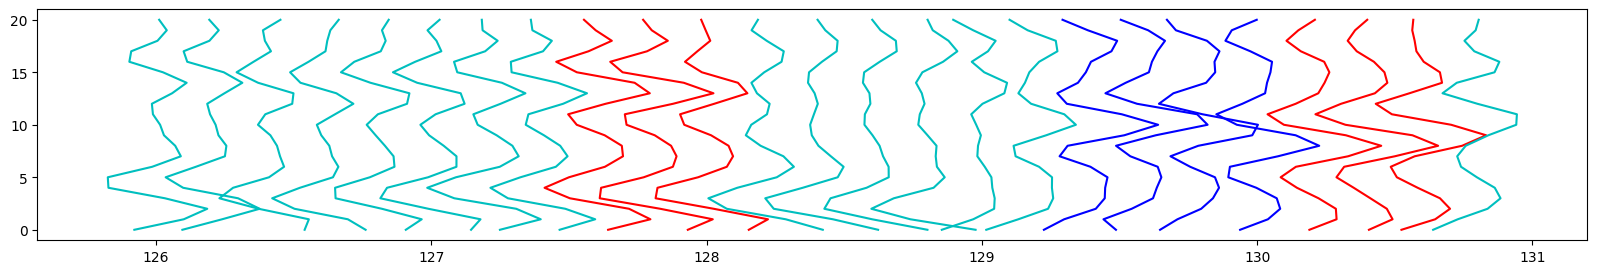

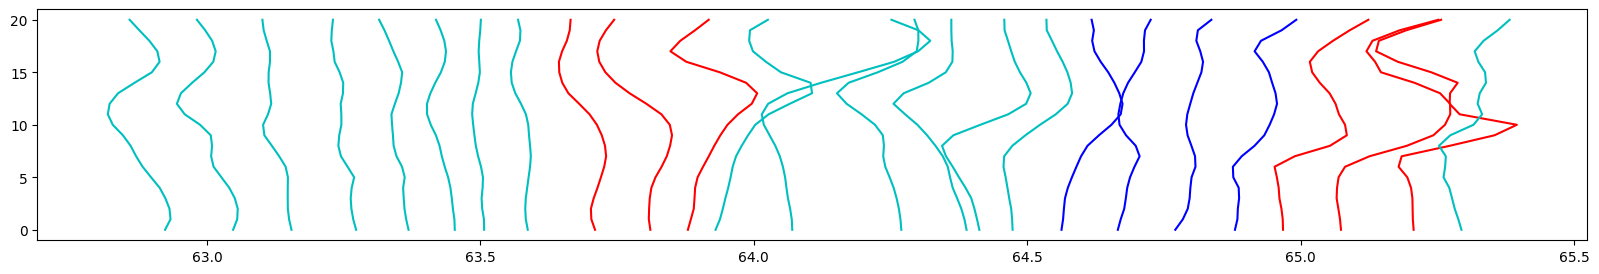

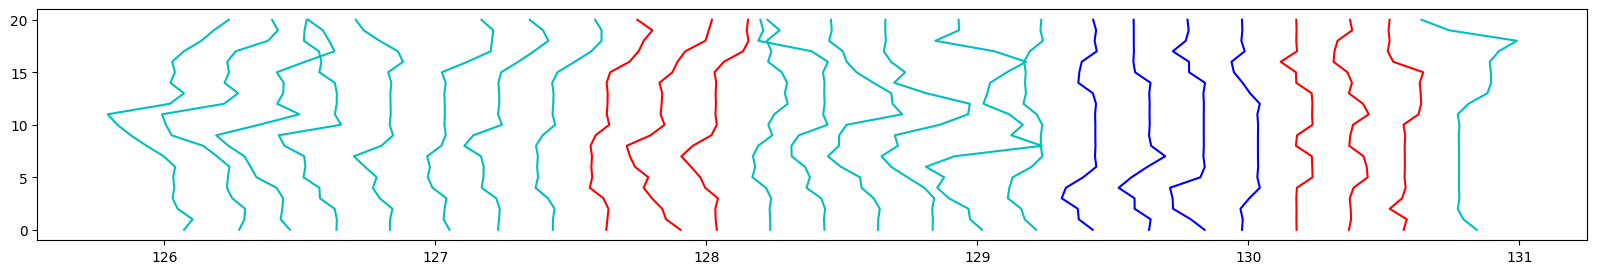

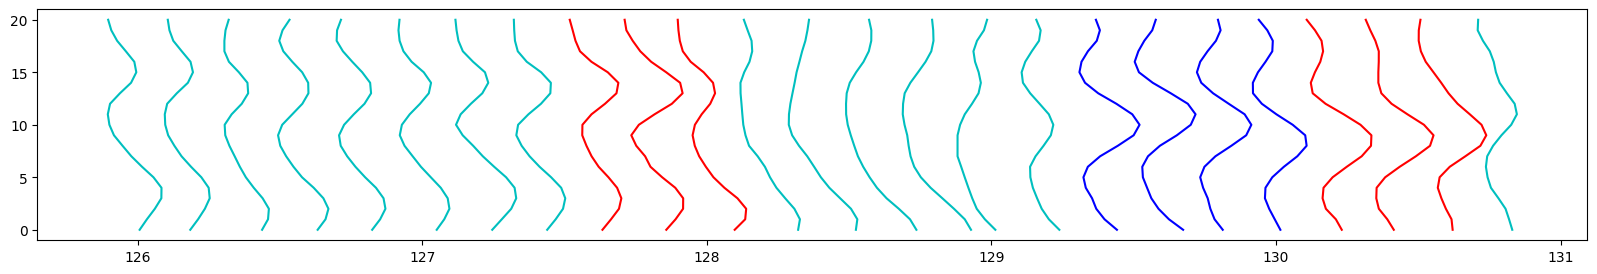

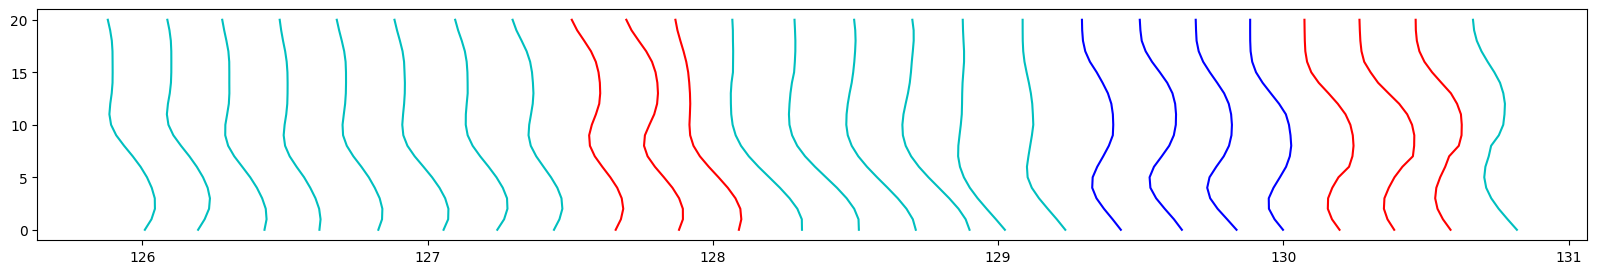

In [37]:
plt.figure(figsize=(20,3))
inline = 380
xl,xr = 1260,1310
d = 2
c = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for i in range(xl,xr,d):
    plt.plot(sx[inline,i,:]/10+i/10,np.arange(21),c=c[int(kmeans[inline,i])])
    # plt.plot(coherent_energy[inline,xl:xr,10])
plt.figure(figsize=(20,3))
for i in range(xl,xr,d):
    plt.plot(k_curvedness[inline,i,:]/5+i/20,np.arange(21),c=c[int(kmeans[inline,i])])
plt.figure(figsize=(20,3))
for i in range(xl,xr,d):
    plt.plot(peak_freq_cmp[inline,i,:]/10+i/10,np.arange(21),c=c[int(kmeans[inline,i])])
plt.figure(figsize=(20,3))
for i in range(xl,xr,d):
    plt.plot(peak_mag_cmp[inline,i,:]/10+i/10,np.arange(21),c=c[int(kmeans[inline,i])])
plt.figure(figsize=(20,3))
for i in range(xl,xr,d):
    plt.plot(coherent_energy[inline,i,:]/5+i/10,np.arange(21),c=c[int(kmeans[inline,i])])

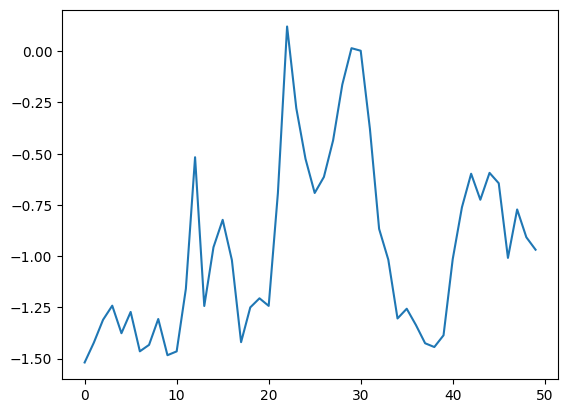

In [40]:
plt.plot(sx[inline,xl:xr,10])

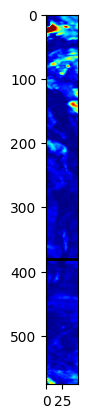

In [32]:
plt.imshow(coherent_energy[:,xl:xr,10],cmap='jet')
plt.scatter(range(0,xr-xl,d),np.ones(len(np.arange(xl,xr,d)))*inline,c='k',s=.5)

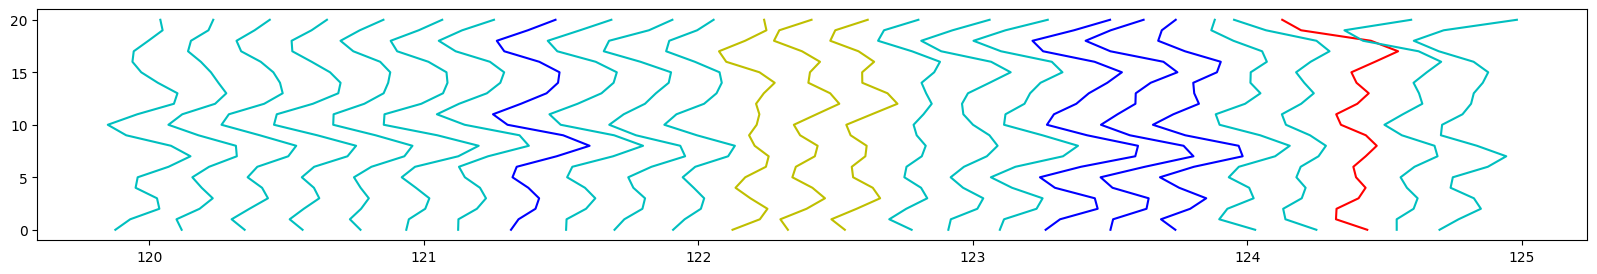

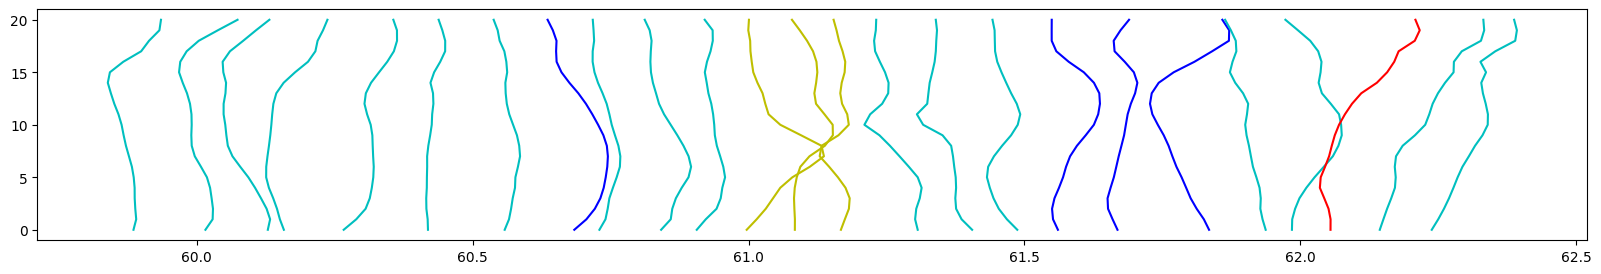

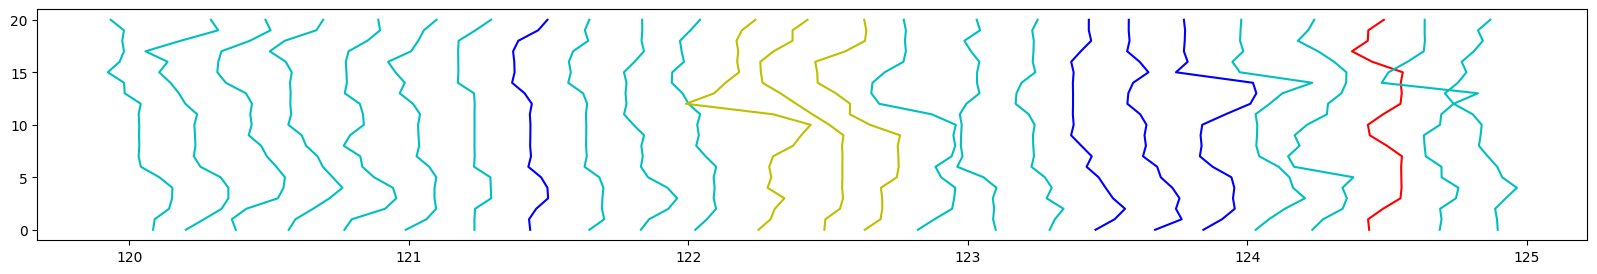

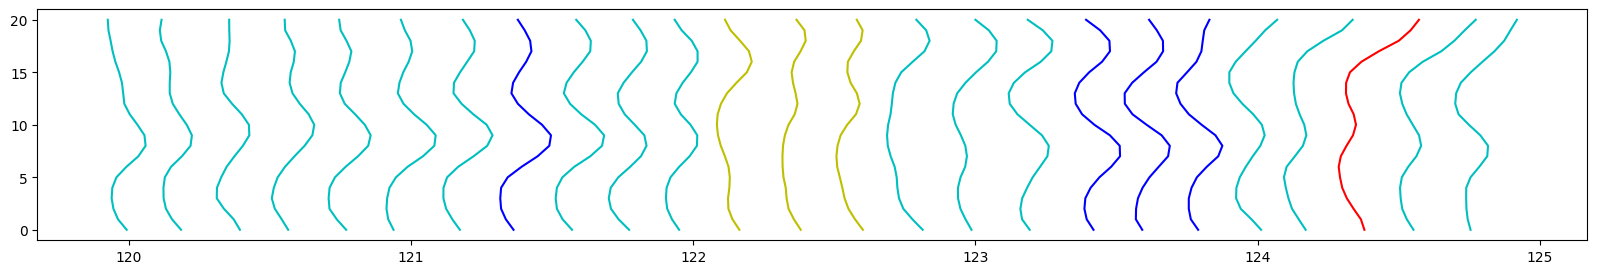

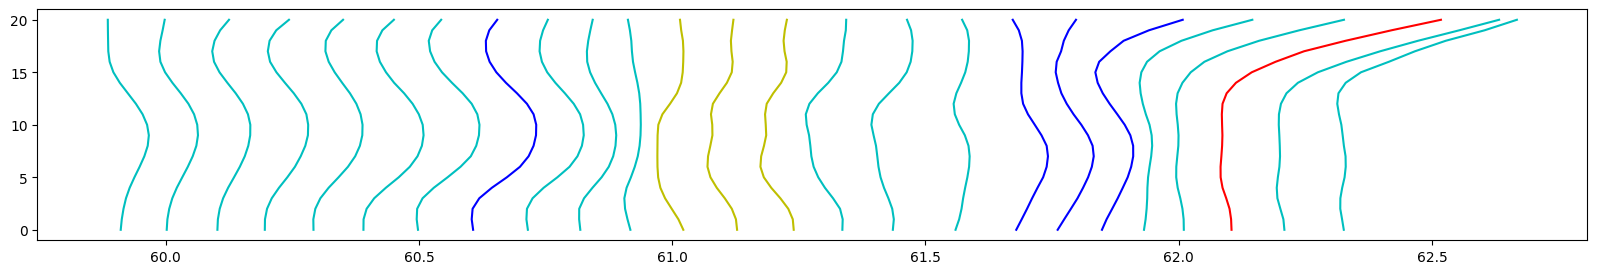

In [38]:
plt.figure(figsize=(20,3))
inline = 310
xl,xr = 1200,1250
d = 2
c = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
for i in range(xl,xr,d):
    plt.plot(sx[inline,i,:]/10+i/10,np.arange(21),c=c[int(kmeans[inline,i])])
plt.figure(figsize=(20,3))
for i in range(xl,xr,d):
    plt.plot(k_curvedness[inline,i,:]/5+i/20,np.arange(21),c=c[int(kmeans[inline,i])])
plt.figure(figsize=(20,3))
for i in range(xl,xr,d):
    plt.plot(peak_freq_cmp[inline,i,:]/10+i/10,np.arange(21),c=c[int(kmeans[inline,i])])
plt.figure(figsize=(20,3))
for i in range(xl,xr,d):
    plt.plot(peak_mag_cmp[inline,i,:]/10+i/10,np.arange(21),c=c[int(kmeans[inline,i])])
plt.figure(figsize=(20,3))
for i in range(xl,xr,d):
    plt.plot(coherent_energy[inline,i,:]/5+i/20,np.arange(21),c=c[int(kmeans[inline,i])])

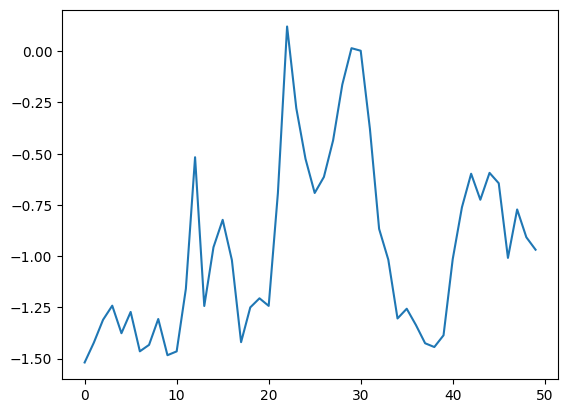

In [41]:
plt.plot(sx[inline,xl:xr,10])

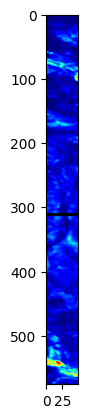

In [12]:
plt.imshow(coherent_energy[:,xl:xr,10],cmap='jet')
plt.scatter(range(0,xr-xl,d),np.ones(len(np.arange(xl,xr,d)))*inline,c='k',s=.5)

In [22]:
int((xr-xl)/d)

60.0

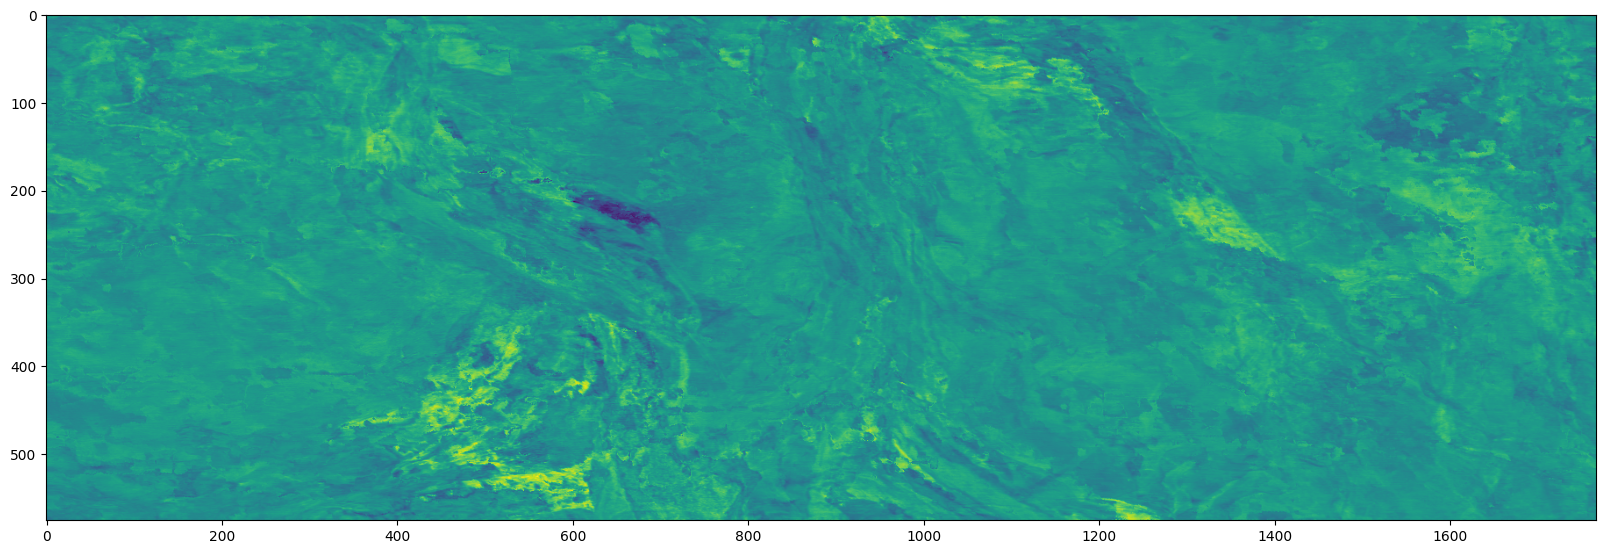

In [6]:
plt.figure(figsize=(20,20))
plt.imshow(np.mean(sxc,axis=-1))

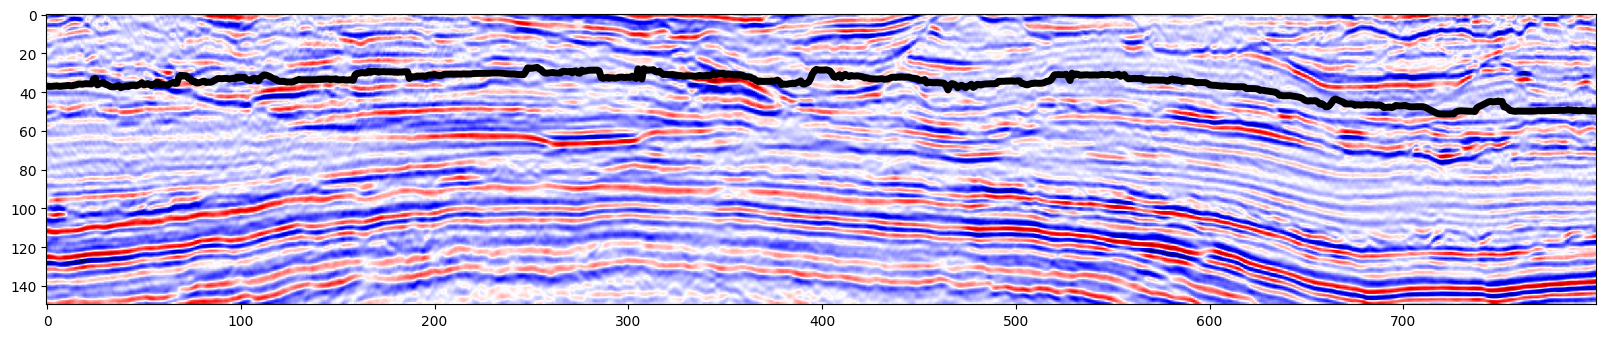

In [13]:
n3,n2,n1 = 576,1767,21
path = "../../../data/jintao/"
plt.figure(figsize=(20,8))
sx = np.fromfile(path+"boCutZhao_150x1767x576.dat", dtype = np.float32).reshape(n3,n2,150)
hor = np.fromfile(path+"p25.dat", dtype = np.float32).reshape(n3,n2)
plt.imshow(sx[20,:800].T,cmap='seismic')
plt.plot(hor[20,:800],'k',linewidth=5)

In [8]:
train_dat = []
train_pos = []
w = 10
for i3 in tqdm(range(n3)):
    for i2 in range(n2):
        h = round(hor[i3,i2])
        train_dat.append(list(sx[i3,i2,h-w:h+w+1])+[i3,i2])
        train_pos.append([i3,i2,h])
train_dat = np.array(train_dat)
train_pos = np.array(train_pos)

  0%|          | 0/576 [00:00<?, ?it/s]

100%|██████████| 576/576 [00:07<00:00, 75.48it/s] 


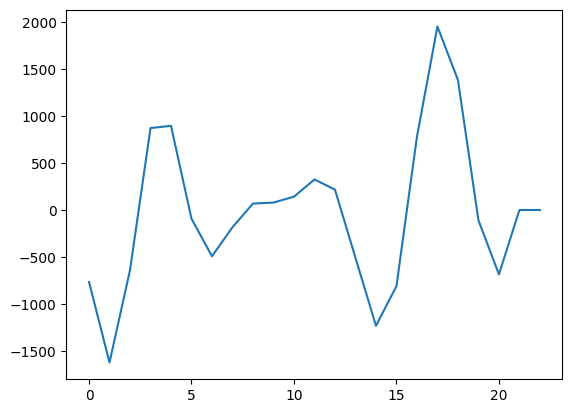

In [11]:
plt.plot(train_dat[0])

In [10]:
mat = np.zeros((n3,n2))-1
pca = PCA(n_components=0.9)
train_dat_pca = pca.fit_transform(train_dat)
print(train_dat_pca.shape)
# kmeans = KMeans(init='k-means++',n_clusters=9,random_state=42,verbose=0).fit(train_dat_pca)
kmeans = MiniBatchKMeans(init='k-means++',n_clusters=7,random_state=42,batch_size=1000000,verbose=0).fit(train_dat_pca)
mat[train_pos[:,0],train_pos[:,1]] = kmeans.labels_

(1017792, 8)


KeyboardInterrupt: 

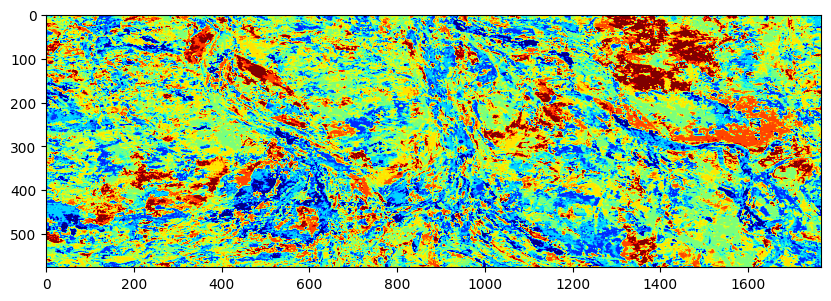

In [ ]:
plt.figure(figsize=(10,6))
plt.imshow(mat,cmap='jet')

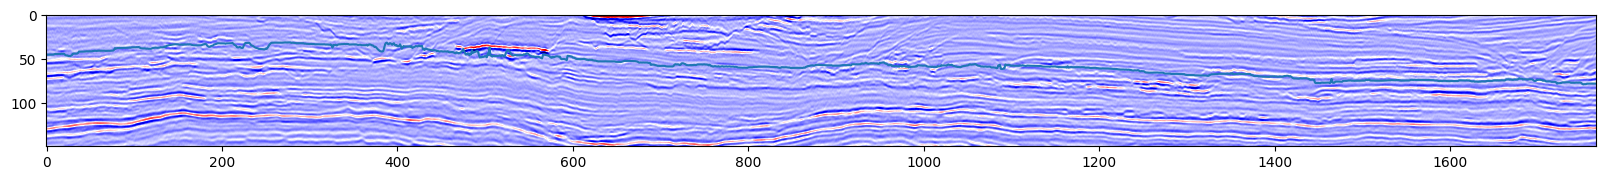

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(sx[180].T,cmap='seismic')
plt.plot(hor[180].T)

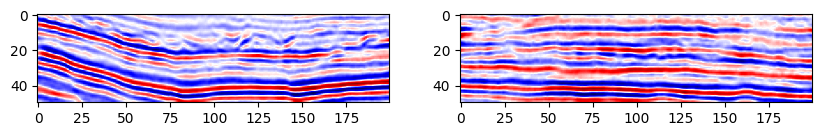

In [ ]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(sx[20,600:800,100:].T,cmap='seismic')
plt.subplot(1,2,2)
plt.imshow(sx[20,1000:1200,75:125].T,cmap='seismic')

(50, 100)


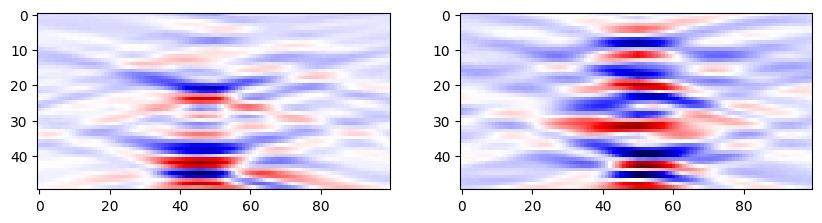

In [ ]:
theta = np.linspace(-30., 30., 100, endpoint=False)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
sinogram = radon(sx[20,600:800,100:], theta=theta)
print(sinogram.shape)
plt.imshow(sinogram,cmap='seismic')
plt.subplot(1,2,2)
sinogram = radon(sx[20,1000:1200,75:125], theta=theta)
plt.imshow(sinogram,cmap='seismic')

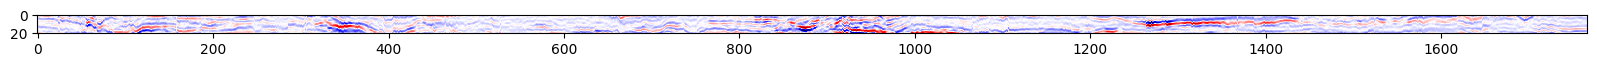

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(sxc[20].T,cmap='seismic')